In [1]:
"""
From https://stackoverflow.com/questions/18228966/how-can-matplotlib-2d-patches-be-transformed-to-3d-with-arbitrary-normals
"""

def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta


In [2]:

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# 3D plotting
from mpl_toolkits import mplot3d
import matplotlib.patches
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Writing
from matplotlib.transforms import Affine2D
from matplotlib.text import TextPath

In [3]:


import collections

Arguments = collections.namedtuple('Settings', 
        ('radius', 'height', 'elevation', 'resolution', 'color', 'x_center', 'y_center','alpha_elements','alpha', 'theta'))

args = Arguments(radius=10, height=3, elevation=0, resolution = 25, color = 'b', x_center=0, y_center=0,alpha_elements= 0.4, alpha=0.2, theta=0.94 )



In [4]:
class Arrow3D(matplotlib.patches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        matplotlib.patches.FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        matplotlib.patches.FancyArrowPatch.draw(self, renderer)

In [5]:
%matplotlib notebook

vop = lambda v1, v2, op, D=3: [op(v1[i], v2[i]) for i in range(D)]
vadd = lambda v1, v2, D=3: vop(v1, v2, lambda x, y: x+y, D)
vmul = lambda v1, v2, D=3: vop(v1, v2, lambda x, y: x*y, D)
vsmul = lambda v1, s, D=3: vmul(v1, (s, s, s), D)
rotcoord = lambda v: v[1:] + v[:1]

def sizescale_init(f):
    f.SIZESCALE = 1.
    return f

@sizescale_init
def write3d(ax, xyz, text, zdir="z", color="k", alpha=1, size=.15, angle=0, usetex=False):
    x, y, z = xyz
    xy1, z1 = ((y, z), x) if zdir=="y" else ((x, y), z)
    text_path = TextPath((0, 0), text, size=size*write3d.SIZESCALE, usetex=usetex)
    trans = Affine2D().rotate(angle).translate(*xy1)
    p = matplotlib.patches.PathPatch(trans.transform_path(text_path), color=color, alpha=alpha)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=z1, zdir=zdir)

def sph2cart(r, theta, phi):
    return np.array([r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)])

def draw_a_range(ax, center=(0, 0), normal=(0, 0, 1), height=0, radius=1, **kwargs):
    c = matplotlib.patches.Circle(center, radius, **kwargs)
    ax.add_patch(c)
    pathpatch_2d_to_3d(c, z=0, normal=normal)

def draw_angle(ax, pos, r, a0, a1, normal, **kwargs):
    angle = matplotlib.patches.Wedge(pos, r, a0*180./np.pi, a1*180./np.pi, **kwargs)
    ax.add_patch(angle)
    pathpatch_2d_to_3d(angle, z=0, normal=normal)
    
def draw_arrows(ax, **kwargs):
    defaults = {"mutation_scale":20, "lw":1, "arrowstyle":"-|>"}
    kwargs.update({k:v for k,v in defaults.items() if not k in kwargs})
    l = 1.0
    for c in "rgb":
        v = Arrow3D([0,l*(c=="r")],[0,l*(c=="g")],[0,l*(c=="b")], color=c, **kwargs)
        ax.add_artist(v)

def draw_axis_sph(ax, pt, theta, phi, **kwargs):
    defaults = {"mutation_scale":20, "lw":1, "arrowstyle":"-|>"}
    kwargs.update({k:v for k,v in defaults.items() if not k in kwargs})
    u_r = (np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta))
    u_theta = (np.cos(phi)*np.cos(theta), np.sin(phi)*np.cos(theta), -np.sin(theta))#/r
    u_phi = (-np.sin(phi), np.cos(phi), 0)
    
    #Rescale axis to make them smaller than (x, y, z)
    u_r, u_theta, u_phi = (vsmul(u, .5) for u in (u_r, u_theta, u_phi))

    for u, c in zip((u_r, u_theta, u_phi), "rgb"):
        v = Arrow3D(*[[pt[i], pt[i]+u[i]] for i in range(3)], color=c, **kwargs)
        ax.add_artist(v)
    
    return u_r, u_theta, u_phi

def draw_volume_element(ax, pt, u_r, u_theta, u_phi, r, theta, phi, **kwargs):
    # Sets arbitrary deltas
    dr, dtheta, dphi = .25, .25, .25
    # Computes real depth, width and height of volume
    d, w, h = vsmul(u_r, dr), vsmul(u_theta, r*dtheta), vsmul(u_phi, r*np.sin(theta)*dphi)
    # Computes the 8 volume vertices
    vertices = [
        pt,
        vadd(pt, h),
        vadd(pt, w),
        vadd(pt, vadd(w, h)),
        vadd(pt, d),
        vadd(pt, vadd(d, h)),
        vadd(pt, vadd(d, w)),
        vadd(pt, vadd(vadd(d, w), h))
    ]
    # Makes an ordering to draw vertices
    p_order = [1, 3, 0, 2, 4, 6, 5, 7, 6, 2, 7, 3, 5, 1, 4, 0]
    p_order = [0, 1, 3, 2, 0, 4, 5, 1, 0, 2, 6, 4, 0, 7, 5, 4, 6, 7, 3, 1, 5, 7, 6, 2, 3, 7]
    points2 = [vertices[i] for i in p_order]
    
    x = [p[0] for p in points2]
    y = [p[1] for p in points2]
    z = [p[2] for p in points2]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, color="r", alpha=.25))    

def plot_segment(ax, a, b, **kwargs):
    ax.plot([a[0], b[0]], [a[1], b[1]], zs=[a[2], b[2]], **kwargs)

def plot_3D_sphere(r, theta, phi):
    # Font size to scale with bigger radii
    write3d.SIZESCALE = r
    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig, azim=30, elev=30)

    # Plot Sphere
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)
    ax.plot_surface(x, y, z, color="r", alpha=.1)
        
    # Plot 3D point
    cart_pos = sph2cart(r, theta, phi)
    cart_positions = np.array([[0, 0, 0], cart_pos]).T
    ax.scatter3D(*cart_positions, c='r')
        

    # Plot segment to point
    plot_segment(ax, [0, 0, 0], cart_pos, lw=1, c="k", alpha=1, linestyle="--")
    
    # Plot angles theta and phi
    theta_normal = (-np.sin(phi), np.cos(phi), 0)
    theta_proj_offset = -np.pi*.5+theta*.5
    draw_angle(ax, (0, 0), r*.25, theta_proj_offset, theta+theta_proj_offset, normal=theta_normal, color="g", alpha=.5)
    draw_angle(ax, (0, 0), r*.25, 0, phi, normal=(0, 0, 1), color="b", alpha=.5)
    
    # Draw circles around sphere in directions of theta and phi to give a 3d feel 
    draw_a_range(ax, radius=r, color="g", height=0, normal=theta_normal, fill=False, linestyle="--", alpha=.66)
    draw_a_range(ax, radius=r, color="b", height=0, normal=(0, 0, 1), fill=False, linestyle="--", alpha=.66)
    
    # Draw axes of (r, theta, phi)
    draw_arrows(ax, lw=1)
    u_r, u_theta, u_phi = draw_axis_sph(ax, cart_pos, theta, phi, lw=1)
    
    # Draw volume?
    DRAW_VOLUME=True
    if DRAW_VOLUME:
        print(cart_pos, u_r, u_theta, u_phi, r, theta, phi)
        draw_volume_element(ax, cart_pos, u_r, u_theta, u_phi, r, theta, phi)
        
        
    # Draw labels of r, theta and phi
    write3d(ax, rotcoord(vsmul(cart_pos, .5)), r"r", zdir="x", color="k", usetex=True)
    theta_label_pos = (np.cos(theta*.5)*1.5*.25, np.sin(theta*.5)*1.5*.25, 0)
    write3d(ax, rotcoord(theta_label_pos), r"$\theta$", zdir="x", color="g", usetex=True)
    phi_label_pos = (np.cos(phi*.5)*1.5*.25, np.sin(phi*.5)*1.5*.25, 0)
    write3d(ax, rotcoord(phi_label_pos), r"$\phi$", zdir="x", color="b", usetex=True)
    
    # Draw labels of cartesian axis
    write3d(ax, rotcoord((r, 0, 0)), r"x", zdir="x", color="r", usetex=True)
    write3d(ax, rotcoord((0, r, 0)), r"y", zdir="x", color="g")
    write3d(ax, rotcoord((0, 0, r)), r"z", zdir="x", color="b")

    # Draw labels of spherical axis
    write3d(ax, rotcoord(vadd(cart_pos, u_r)), r"ur", zdir="x", color="r")
    write3d(ax, rotcoord(vadd(cart_pos, u_theta)), r"u$\theta$", zdir="x", color="g")
    write3d(ax, rotcoord(vadd(cart_pos, u_phi)), r"u$\phi$", zdir="x", color="b")

    plt.show()


<IPython.core.display.Javascript object>


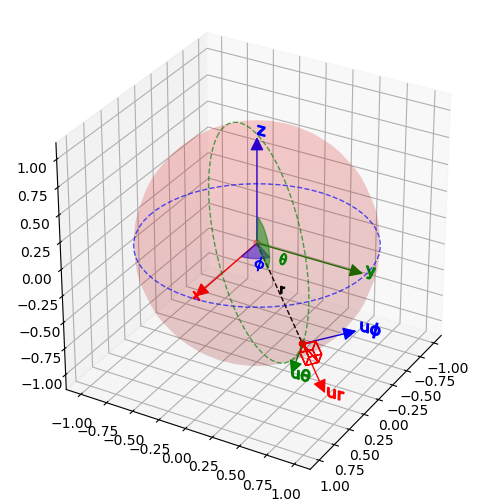

[ 0.52372049  0.72083942 -0.4539905 ] [0.2618602473071497, 0.36041971008367113, -0.22699524986977337] [-0.13342446021389773, -0.18364301478703424, -0.44550326209418395] [-0.4045084971874737, 0.29389262614623657, 0.0] 1 2.0420352248333655 0.9424777960769379


In [6]:

plot_3D_sphere(1, np.pi*.65, np.pi*.3)

## Surface element

In [7]:

pt, u_r, u_theta, u_phi, r, theta, phi = (
    [ 0.52372049, 0.72083942, -0.4539905 ],
    [0.2618602473071497, 0.36041971008367113, -0.22699524986977337],
    [-0.13342446021389773, -0.18364301478703424, -0.44550326209418395],
    [-0.4045084971874737, 0.29389262614623657, 0.0],
    1,
    2.0420352248333655,
    0.9424777960769379
)

def draw_volume_element(ax, pt, u_r, u_theta, u_phi, r, theta, phi, **kwargs):
    # Sets arbitrary deltas
    dr, dtheta, dphi = .25, .25, .25
    # Computes real depth, width and height of volume
    d, w, h = vsmul(u_r, dr), vsmul(u_theta, r*dtheta), vsmul(u_phi, r*np.sin(theta)*dphi)
    # Computes the 8 volume vertices
    vertices = [
        pt,
        vadd(pt, h),
        vadd(pt, w),
        vadd(pt, vadd(w, h)),
        vadd(pt, d),
        vadd(pt, vadd(d, h)),
        vadd(pt, vadd(d, w)),
        vadd(pt, vadd(vadd(d, w), h))
    ]
    # Makes an ordering to draw vertices
    p_order = [1, 3, 0, 2, 4, 6, 5, 7, 6, 2, 7, 3, 5, 1, 4, 0]
    p_order = [0, 1, 3, 2, 0, 4, 5, 1, 0, 2, 6, 4, 0, 7, 5, 4, 6, 7, 3, 1, 5, 7, 6, 2, 3, 7]
    points2 = [vertices[i] for i in p_order]
    
    x = [p[0] for p in points2]
    y = [p[1] for p in points2]
    z = [p[2] for p in points2]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, color="r", alpha=.25))    

def draw_view():

    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig, azim=70, elev=-50)

    u_r, u_theta, u_phi = draw_axis_sph(ax, pt, theta, phi, lw=1)
    plot_segment(ax, [0, 0, 0], pt, lw=2, c="orange")

    draw_volume_element(ax, pt, u_r, u_theta, u_phi, r, theta, phi)

    text3d(ax, vadd(pt, u_r), r"ur", zdir="z", color="r", usetex=True, ec="none", fc="k")
    text3d(ax, vadd(pt, u_theta), r"u$\theta$", zdir="z", color="g", usetex=True, ec="none", fc="k")
    text3d(ax, vadd(pt, u_phi), r"u$\phi$", zdir="z", color="b", usetex=True, ec="none", fc="k")
#draw_view()